<a href="https://colab.research.google.com/github/UdalovIA/Data_Mining_Lab/blob/main/ML_Cup_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://storage.yandexcloud.net/audioml-contest22/dataset.tar.gz", "dataset.tar.gz")

In [ ]:
#!python naive_baseline.py --features-dir /content/train_features --tracks-meta /content/train_meta.tsv --output /content/out/text.txt

In [ ]:
from google.colab import drive
drive.mount('drive')
#!cp /content/train_meta.tsv "drive/My Drive/"

Mounted at drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/train_features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_features')

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/train_meta.tsv", "/content/")

'/content/train_meta.tsv'

In [ ]:
!cp /content/train_meta.tsv "drive/My Drive/"

In [ ]:
import tarfile
import zipfile
zipfile = '/content/dataset.tar.gz'
if zipfile.endswith("tar.gz"):
    tar = tarfile.open(zipfile, "r:gz")
elif zipfile.endswith("tar"):
    tar = tarfile.open(zipfile, "r:")
tar.extractall()
tar.close()  

In [ ]:
!pip install annoy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 25.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=388775 sha256=d3db21cbc8bfa513ad12adab12d9bdeb927dea045ddddd644d0184da7b4c82cc
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
Successfully built annoy


In [ ]:
# encoding=utf-8
import numpy as np
import pandas as pd
import os
from argparse import ArgumentParser
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from tqdm import tqdm
import random
import annoy

In [ ]:


# Data Loader 

def train_val_split(dataset, val_size = 0.2): # Сплит по artistid
    artist_ids = dataset['artistid'].unique()
    train_artist_ids, val_artist_ids = train_test_split(artist_ids, test_size = val_size)
    trainset = dataset[dataset['artistid'].isin(train_artist_ids)].copy()
    valset = dataset[dataset['artistid'].isin(val_artist_ids)].copy()
    return trainset, valset

class FeaturesLoader: 
    def __init__(self, features_dir_path, meta_info, device='cpu', crop_size = 60):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index('trackid')['archive_features_path'].to_dict()
        self.crop_size = crop_size
        self.device = device
        
    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        track_features = np.load(os.path.join(self.features_dir_path, track_features_file_path))
        padding = (track_features.shape[1] - self.crop_size) // 2
        return track_features[:, padding:padding+self.crop_size]
    
    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)

class TrainLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby('artistid').agg(list)
        
    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i-2:i] for i in range(2, len(track_ids)+1, 2)]
        return pairs
        
    def _get_pair_ids(self):
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids['trackid'].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            yield pair_ids
            
    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features
        
    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

class TestLoader:
    def __init__(self, features_loader, batch_size = 256, features_size = (512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        
    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info['trackid'].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids) 
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids) 





In [ ]:
# Loss & Metrics

class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
 
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        with torch.no_grad():
            top1_negative_samples, _ = negative_samples.topk(1)
            avg_rank = logits.argsort(descending=True).argmin(dim=1).float().mean().cpu().numpy()

        return loss, avg_rank

def get_ranked_list(embeds, top_size, annoy_num_trees = 32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), 'angular')
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size+1)[1:] # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list

def position_discounter(position):
    return 1.0 / np.log2(position+1)   

def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg

def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

def eval_submission(submission, gt_meta_info, top_size = 100):
    track2artist_map = gt_meta_info.set_index('trackid')['artistid'].to_dict()
    artist2tracks_map = gt_meta_info.groupby('artistid').agg(list)['trackid'].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count-1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map, top_size=top_size)
        try:
            ndcg_list.append(dcg/ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


In [ ]:
def train(module, train_loader, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    metric1 = []
    metric2 = []
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss, avg_rank = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print("avg_rank: {}".format(avg_rank))
            print()
            losses.append(loss.item())
        
        with torch.no_grad():
            model_encoder = module.encoder
            embeds_encoder = inference(model_encoder, val_loader)
            ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)
            
            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)
            metric1.append(val_ndcg_encoder)
            metric2.append(val_ndcg_projector)
    return losses, metric1, metric2
def save_submission(submission, submission_path):
    with open(submission_path, 'w') as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))

In [ ]:
# Train & Inference functions

class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.kernel = 3
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_2 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(output_features_size, output_features_size, kernel_size=self.kernel, padding=1)
        self.conv_4 = nn.Conv1d(output_features_size, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.mp_2 = nn.MaxPool1d(2, 2)
        self.conv_5 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.conv_6 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)

        self.mp_3 = nn.MaxPool1d(2, 2)
        self.conv_7 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)
        self.conv_8 = nn.Conv1d(output_features_size//2, output_features_size//2, kernel_size=self.kernel, padding=1)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = self.mp_2(x)
        '''
        x = F.relu(self.conv_5(x))
        x = (self.conv_6(x))
        x = self.mp_3(x)
        '''
        x = F.relu(self.conv_7(x))
        x = F.relu(self.conv_8(x)).mean(axis = 2)
        return x

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size//2
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )
        
    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)#.view(-1, 128*15)
        h_j = self.encoder(x_j)#.view(-1, 128*15)
        #print(x_i.shape)

        #print('h_i.shape: ', h_i.shape)
        #print(h_j.shape)
        
        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        #z_i = self.projector(h_i.view(-1, 64*15))
        #z_j = self.projector(h_j.view(-1, 64*15))
        return h_i, h_j, z_i, z_j
#(32768x15 and 64x64)
def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)#.view(-1, 128*15)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds
def inference1(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model[1](model[0](tracks_features))#.view(-1, 64*15))
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds

In [ ]:

#parser = ArgumentParser(description='Simple naive baseline')
#parser.add_argument('--base-dir', dest='base_dir', action='store', required=True)
#args = parser.parse_args()

base_dir = '/content'
    # Seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

TRAINSET_DIRNAME = 'train_features'
TESTSET_DIRNAME = 'test_features'
TRAINSET_META_FILENAME = 'train_meta.tsv'
TESTSET_META_FILENAME = 'test_meta.tsv'
SUBMISSION_FILENAME = 'submission.txt'
MODEL_FILENAME = 'model.pt'
CHECKPOINT_FILENAME = 'best.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 512
N_CHANNELS = 512
PROJECTION_DIM = 128
NUM_EPOCHS = 20
LR = 1e-4
TEMPERATURE = 0.1

TRAINSET_PATH = os.path.join(base_dir, TRAINSET_DIRNAME)
TESTSET_PATH = os.path.join(base_dir, TESTSET_DIRNAME)
TRAINSET_META_PATH = os.path.join(base_dir, TRAINSET_META_FILENAME)
TESTSET_META_PATH = os.path.join(base_dir, TESTSET_META_FILENAME)
SUBMISSION_PATH = os.path.join(base_dir, SUBMISSION_FILENAME)
MODEL_PATH = os.path.join(base_dir, MODEL_FILENAME)
CHECKPOINT_PATH = os.path.join(base_dir, CHECKPOINT_FILENAME)

In [ ]:

sim_clr = SimCLR(
    encoder = BasicNet(N_CHANNELS),
    projection_dim = PROJECTION_DIM
).to(device)
'''
autoen = Autoencoder(
    output_features_size = 512,
).to(device)
sim_clr = SimCLR(
    encoder = autoen.encoder,
    projection_dim = PROJECTION_DIM
).to(device)
'''
train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep='\t')
#test_meta_info = pd.read_csv(TESTSET_META_PATH, sep='\t')
train_meta_info, validation_meta_info = train_val_split(train_meta_info, val_size=0.1)

print("Loaded data")
print("Train set size: {}".format(len(train_meta_info)))
print("Validation set size: {}".format(len(validation_meta_info)))
#print("Test set size: {}".format(len(test_meta_info)))
print()

print("Train")
l,m1,m2 = train(
        module = sim_clr,
        train_loader = TrainLoader(FeaturesLoader(TRAINSET_PATH, train_meta_info, device), batch_size = BATCH_SIZE),
        val_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
        valset_meta = validation_meta_info,
        optimizer = torch.optim.Adam(sim_clr.parameters(), lr = LR),
        criterion = NT_Xent(temperature = TEMPERATURE),
        num_epochs = NUM_EPOCHS,
        checkpoint_path = CHECKPOINT_PATH
)

print("Submission")
#test_loader = TestLoader(FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size = BATCH_SIZE)
#model = sim_clr.encoder
#embeds = inference(model, test_loader)
#submission = get_ranked_list(embeds, 100)
#save_submission(submission, SUBMISSION_PATH)
#torch.save(sim_clr.state_dict(), MODEL_PATH)'''

Loaded data
Train set size: 150484
Validation set size: 16712

Train


0it [00:09, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
sim_clr = torch.load('/content/modelka_5')

In [ ]:
train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep='\t')
test_meta_info = pd.read_csv(TESTSET_META_PATH, sep='\t')
train_meta_info, validation_meta_info = train_val_split(train_meta_info, val_size=0.1)

In [ ]:
test_loader = TestLoader(FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size = BATCH_SIZE)
model = sim_clr.encoder
embeds = inference(model, test_loader)
submission = get_ranked_list(embeds, 100)
save_submission(submission, SUBMISSION_PATH)
torch.save(sim_clr.state_dict(), MODEL_PATH)

100%|██████████| 41377/41377 [05:01<00:00, 137.36it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

from vector_quantize_pytorch import ResidualVQ

# Generator


class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1)

    def forward(self, x):
        return self._conv_forward(F.pad(x, [self.causal_padding, 0]), self.weight, self.bias)


class CausalConvTranspose1d(nn.ConvTranspose1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1) + self.output_padding[0] + 1 - self.stride[0]
    
    def forward(self, x, output_size=None):
        if self.padding_mode != 'zeros':
            raise ValueError('Only `zeros` padding mode is supported for ConvTranspose1d')

        assert isinstance(self.padding, tuple)
        output_padding = self._output_padding(
            x, output_size, self.stride, self.padding, self.kernel_size, self.dilation)
        return F.conv_transpose1d(
            x, self.weight, self.bias, self.stride, self.padding,
            output_padding, self.groups, self.dilation)[...,:-self.causal_padding]


class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__()
        
        self.dilation = dilation

        self.layers = nn.Sequential(
            CausalConv1d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=7, dilation=dilation),
            nn.ELU(),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=1)
        )

    def forward(self, x):
        return x + self.layers(x)


class EncoderBlock(nn.Module):
    def __init__(self, out_channels, stride):
        super().__init__()
        
        self.layers = nn.Sequential(
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=1),
            nn.ELU(),
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=3),
            nn.ELU(),
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=9),
            nn.ELU(),
            CausalConv1d(in_channels=out_channels//2, out_channels=out_channels,
                      kernel_size=2*stride, stride=stride)
        )

    def forward(self, x):
        return self.layers(x)

class Encoder(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.output_features_size = D
        self.layers = nn.Sequential(
            CausalConv1d(in_channels=512, out_channels=C, kernel_size=7),
            nn.ELU(),
            EncoderBlock(out_channels=2*C, stride=2),
            nn.ELU(),
            EncoderBlock(out_channels=4*C, stride=4),
            nn.ELU(),
            EncoderBlock(out_channels=8*C, stride=5),
            nn.ELU(),
            EncoderBlock(out_channels=16*C, stride=8),
            nn.ELU(),
            CausalConv1d(in_channels=16*C, out_channels=D, kernel_size=3)
        )

    def forward(self, x):
        return self.layers(x)

**Encoder**

In [ ]:
def train_ae(module, train_loader,optimizer, criterion, num_epochs): #, val_loader, valset_meta, optimizer, criterion, num_epochs, checkpoint_path, top_size = 100):
    max_ndcg = None
    losses = []
    for epoch in range(num_epochs):
        for tracks_ids, tracks_features in train_loader:
            optimizer.zero_grad()
            module.train()
            reconstructed, _ = module(tracks_features)
            loss = criterion(reconstructed, tracks_features)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("loss: {}".format(loss))
            print()
            losses.append(loss.item())
        '''with torch.no_grad():
            module.eval()
            for X_batch in val_loader:
                X_batch = X_batch.view(-1, 3, 64, 64).float()
                reconstructed, _ = model(X_batch.to(device))
                loss = loss_fn(reconstructed.view(-1, 3, 64, 64), X_batch.to(device))
                val_losses_per_epoch.append(loss.item())
            
            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)'''
    return losses

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.n_features = output_features_size

        self.encoder = nn.Sequential(
            nn.Conv1d(512, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features, self.n_features, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features, self.n_features//2, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//2, self.n_features//2, kernel_size=3, padding=1),

            nn.Conv1d(self.n_features//2, self.n_features//2, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//2, self.n_features//4, kernel_size=3, padding=1),

            nn.MaxPool1d(2, 2, return_indices=False),

            nn.Conv1d(self.n_features//4, self.n_features//4, kernel_size=3, padding=1),
            nn.Conv1d(self.n_features//4, self.n_features//4, kernel_size=3, padding=1)
        )
       
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(self.n_features//4, self.n_features//4, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//4, self.n_features//4,stride =2, kernel_size=3, padding=0),
           #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features//4, self.n_features//2, kernel_size=3, padding=1),
            nn.ConvTranspose1d(self.n_features//2, self.n_features//2, kernel_size=3, padding=1),
            #nn.MaxUnpool1d(2),
            nn.ConvTranspose1d(self.n_features//2, self.n_features,stride = 2,kernel_size=2, padding=1),
            nn.ConvTranspose1d(self.n_features, self.n_features, kernel_size=3, padding=1)
        )

    def forward(self, x):
        #print('x.shape ' , x.shape)
        latent = self.encoder(x) #.view(-1, 512)
        #print('latent.shape ' ,latent.shape)
        #latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        #print('reconstructed.shape ' ,reconstructed.shape)
        return reconstructed, latent


In [ ]:
autoen = Autoencoder(
    output_features_size = 512,
).to(device)

In [ ]:
autoen.encoder

Sequential(
  (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (6): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [ ]:
losses = train_ae(module= autoen,
         train_loader = TestLoader(FeaturesLoader(TRAINSET_PATH, validation_meta_info, device), batch_size = BATCH_SIZE),
         optimizer = torch.optim.Adam(autoen.parameters(), lr = LR),
         criterion = F.mse_loss,
         num_epochs = NUM_EPOCHS)

  1%|          | 512/44800 [00:00<01:05, 675.75it/s]

Epoch 1/20
loss: 0.2880333662033081

Epoch 1/20
loss: 0.2836017608642578



  3%|▎         | 1536/44800 [00:02<01:23, 520.58it/s]

Epoch 1/20
loss: 0.28045207262039185



  5%|▍         | 2048/44800 [00:04<01:39, 431.79it/s]

Epoch 1/20
loss: 0.28080520033836365



  6%|▌         | 2560/44800 [00:05<01:40, 418.91it/s]

Epoch 1/20
loss: 0.2804797291755676



  7%|▋         | 3072/44800 [00:06<01:39, 417.48it/s]

Epoch 1/20
loss: 0.27394720911979675



  8%|▊         | 3584/44800 [00:07<01:36, 427.59it/s]

Epoch 1/20
loss: 0.2738777995109558

Epoch 1/20


  9%|▉         | 4096/44800 [00:09<01:41, 400.17it/s]

loss: 0.26826682686805725

Epoch 1/20


 10%|█         | 4608/44800 [00:10<01:45, 381.09it/s]

loss: 0.2602991759777069



 11%|█▏        | 5120/44800 [00:12<01:47, 367.50it/s]

Epoch 1/20
loss: 0.2538875639438629



 13%|█▎        | 5632/44800 [00:13<01:47, 365.93it/s]

Epoch 1/20
loss: 0.2339681088924408

Epoch 1/20


 14%|█▎        | 6144/44800 [00:15<01:45, 365.82it/s]

loss: 0.2085048407316208



 15%|█▍        | 6656/44800 [00:16<01:44, 365.04it/s]

Epoch 1/20
loss: 0.17056430876255035



 16%|█▌        | 7168/44800 [00:18<01:44, 359.50it/s]

Epoch 1/20
loss: 0.17878147959709167

Epoch 1/20
loss: 0.16831596195697784



 18%|█▊        | 8192/44800 [00:20<01:41, 359.25it/s]

Epoch 1/20
loss: 0.14492356777191162



 19%|█▉        | 8704/44800 [00:22<01:41, 357.35it/s]

Epoch 1/20
loss: 0.14487820863723755



 21%|██        | 9216/44800 [00:23<01:39, 356.17it/s]

Epoch 1/20
loss: 0.15003640949726105



 22%|██▏       | 9728/44800 [00:25<01:39, 352.91it/s]

Epoch 1/20
loss: 0.1485280841588974



 23%|██▎       | 10240/44800 [00:26<01:38, 351.32it/s]

Epoch 1/20
loss: 0.14142560958862305



 24%|██▍       | 10752/44800 [00:28<01:36, 351.47it/s]

Epoch 1/20
loss: 0.13748781383037567



 25%|██▌       | 11264/44800 [00:29<01:35, 349.62it/s]

Epoch 1/20
loss: 0.13317200541496277



 26%|██▋       | 11776/44800 [00:31<01:34, 349.36it/s]

Epoch 1/20
loss: 0.14295431971549988



 27%|██▋       | 12288/44800 [00:32<01:33, 347.78it/s]

Epoch 1/20
loss: 0.13885468244552612



 29%|██▊       | 12800/44800 [00:34<01:34, 337.86it/s]

Epoch 1/20
loss: 0.13553312420845032



 30%|██▉       | 13312/44800 [00:35<01:33, 336.29it/s]

Epoch 1/20
loss: 0.13372403383255005



 31%|███       | 13824/44800 [00:37<01:31, 339.49it/s]

Epoch 1/20
loss: 0.13594815135002136



 32%|███▏      | 14336/44800 [00:38<01:27, 346.19it/s]

Epoch 1/20
loss: 0.13748173415660858



 33%|███▎      | 14848/44800 [00:40<01:26, 345.80it/s]

Epoch 1/20
loss: 0.13687710464000702



 34%|███▍      | 15360/44800 [00:41<01:25, 344.04it/s]

Epoch 1/20
loss: 0.132197305560112



 35%|███▌      | 15872/44800 [00:43<01:24, 342.33it/s]

Epoch 1/20
loss: 0.13102121651172638



 37%|███▋      | 16384/44800 [00:44<01:22, 345.65it/s]

Epoch 1/20
loss: 0.13524849712848663



 38%|███▊      | 16896/44800 [00:46<01:20, 347.65it/s]

Epoch 1/20
loss: 0.13474230468273163



 39%|███▉      | 17408/44800 [00:47<01:19, 343.68it/s]

Epoch 1/20
loss: 0.13237591087818146



 40%|████      | 17920/44800 [00:49<01:18, 344.39it/s]

Epoch 1/20
loss: 0.13215716183185577



 41%|████      | 18432/44800 [00:50<01:15, 347.43it/s]

Epoch 1/20
loss: 0.13239765167236328



 42%|████▏     | 18944/44800 [00:52<01:13, 349.82it/s]

Epoch 1/20
loss: 0.13440677523612976



 43%|████▎     | 19456/44800 [00:53<01:12, 350.53it/s]

Epoch 1/20
loss: 0.1323341280221939



 45%|████▍     | 19968/44800 [00:54<01:10, 352.93it/s]

Epoch 1/20
loss: 0.13391193747520447



 46%|████▌     | 20480/44800 [00:56<01:08, 357.37it/s]

Epoch 1/20
loss: 0.13144750893115997



 47%|████▋     | 20992/44800 [00:57<01:05, 361.89it/s]

Epoch 1/20
loss: 0.1310926079750061



 48%|████▊     | 21504/44800 [00:59<01:04, 361.42it/s]

Epoch 1/20
loss: 0.13078059256076813



 49%|████▉     | 22016/44800 [01:00<01:04, 354.79it/s]

Epoch 1/20
loss: 0.13156762719154358



 50%|█████     | 22528/44800 [01:02<01:02, 355.44it/s]

Epoch 1/20
loss: 0.12923532724380493



 51%|█████▏    | 23040/44800 [01:03<01:01, 356.41it/s]

Epoch 1/20
loss: 0.13077804446220398



 53%|█████▎    | 23552/44800 [01:04<00:58, 360.57it/s]

Epoch 1/20
loss: 0.13144437968730927



 54%|█████▎    | 24064/44800 [01:06<00:57, 361.14it/s]

Epoch 1/20
loss: 0.13067670166492462



 55%|█████▍    | 24576/44800 [01:07<00:56, 358.58it/s]

Epoch 1/20
loss: 0.13010528683662415



 56%|█████▌    | 25088/44800 [01:09<00:54, 360.49it/s]

Epoch 1/20
loss: 0.1323729157447815



 57%|█████▋    | 25600/44800 [01:10<00:53, 359.69it/s]

Epoch 1/20
loss: 0.13012456893920898



 58%|█████▊    | 26112/44800 [01:11<00:51, 361.43it/s]

Epoch 1/20
loss: 0.13144278526306152



 59%|█████▉    | 26624/44800 [01:13<00:50, 360.44it/s]

Epoch 1/20
loss: 0.12979908287525177



 61%|██████    | 27136/44800 [01:14<00:49, 357.89it/s]

Epoch 1/20
loss: 0.13004206120967865



 62%|██████▏   | 27648/44800 [01:16<00:48, 354.28it/s]

Epoch 1/20
loss: 0.12991103529930115



 63%|██████▎   | 28160/44800 [01:17<00:46, 355.57it/s]

Epoch 1/20
loss: 0.13071522116661072



 64%|██████▍   | 28672/44800 [01:19<00:46, 350.41it/s]

Epoch 1/20
loss: 0.12879538536071777



 65%|██████▌   | 29184/44800 [01:20<00:45, 342.46it/s]

Epoch 1/20
loss: 0.1285291165113449



 66%|██████▋   | 29696/44800 [01:22<00:44, 340.72it/s]

Epoch 1/20
loss: 0.1300046741962433



 67%|██████▋   | 30208/44800 [01:23<00:42, 344.34it/s]

Epoch 1/20
loss: 0.13087816536426544



 69%|██████▊   | 30720/44800 [01:25<00:40, 344.69it/s]

Epoch 1/20
loss: 0.13031595945358276



 70%|██████▉   | 31232/44800 [01:26<00:39, 342.14it/s]

Epoch 1/20
loss: 0.12821242213249207



 71%|███████   | 31744/44800 [01:28<00:37, 344.90it/s]

Epoch 1/20
loss: 0.1286560744047165



 72%|███████▏  | 32256/44800 [01:29<00:36, 347.90it/s]

Epoch 1/20
loss: 0.1281888484954834



 73%|███████▎  | 32768/44800 [01:31<00:34, 351.44it/s]

Epoch 1/20
loss: 0.12911339104175568



 74%|███████▍  | 33280/44800 [01:32<00:32, 351.69it/s]

Epoch 1/20
loss: 0.12984763085842133



 75%|███████▌  | 33792/44800 [01:33<00:31, 354.28it/s]

Epoch 1/20
loss: 0.1294097751379013



 77%|███████▋  | 34304/44800 [01:35<00:29, 356.95it/s]

Epoch 1/20
loss: 0.12978172302246094



 78%|███████▊  | 34816/44800 [01:36<00:27, 360.22it/s]

Epoch 1/20
loss: 0.13012278079986572



 79%|███████▉  | 35328/44800 [01:38<00:26, 364.18it/s]

Epoch 1/20
loss: 0.13044963777065277



 80%|████████  | 35840/44800 [01:39<00:24, 360.85it/s]

Epoch 1/20
loss: 0.12676459550857544



 81%|████████  | 36352/44800 [01:41<00:23, 362.51it/s]

Epoch 1/20
loss: 0.12919580936431885



 82%|████████▏ | 36864/44800 [01:42<00:21, 361.93it/s]

Epoch 1/20
loss: 0.12821316719055176



 83%|████████▎ | 37376/44800 [01:43<00:20, 360.29it/s]

Epoch 1/20
loss: 0.12833496928215027



 85%|████████▍ | 37888/44800 [01:45<00:19, 357.78it/s]

Epoch 1/20
loss: 0.1285330057144165



 86%|████████▌ | 38399/44800 [01:46<00:17, 361.87it/s]


KeyboardInterrupt: ignored

In [ ]:
with open("losses.txt", "w") as output:
    output.write(str(l))

In [ ]:
with open("met1.txt", "w") as output:
    output.write(str(m1))

In [ ]:
with open("met2.txt", "w") as output:
    output.write(str(m2))

In [ ]:
plt.plot(losses)

NameError: ignored

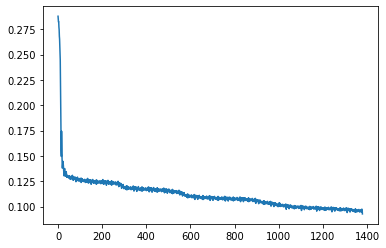

In [ ]:

plt.plot(losses)

In [ ]:
l1, m11, m21 = l, m1, m2

NameError: ignored

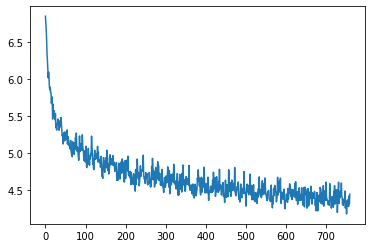

In [ ]:
import matplotlib.pyplot as plt

plt.plot(l)

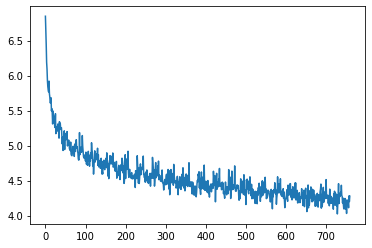

In [ ]:
plt.plot(l1)

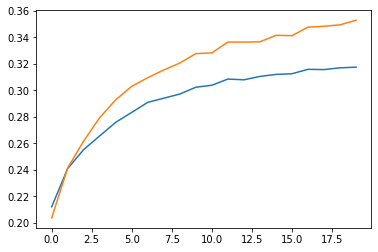

In [ ]:
plt.plot(m1)
plt.plot(m2)

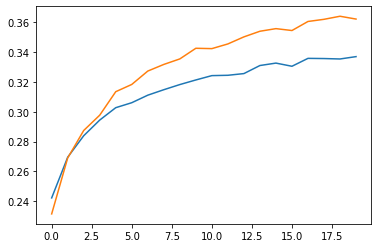

In [ ]:
plt.plot(m11)
plt.plot(m21)

In [ ]:
!pip install vector_quantize_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 514 kB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

from vector_quantize_pytorch import ResidualVQ

# Generator


class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1)

    def forward(self, x):
        return self._conv_forward(F.pad(x, [self.causal_padding, 0]), self.weight, self.bias)


class CausalConvTranspose1d(nn.ConvTranspose1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1) + self.output_padding[0] + 1 - self.stride[0]
    
    def forward(self, x, output_size=None):
        if self.padding_mode != 'zeros':
            raise ValueError('Only `zeros` padding mode is supported for ConvTranspose1d')

        assert isinstance(self.padding, tuple)
        output_padding = self._output_padding(
            x, output_size, self.stride, self.padding, self.kernel_size, self.dilation)
        return F.conv_transpose1d(
            x, self.weight, self.bias, self.stride, self.padding,
            output_padding, self.groups, self.dilation)[...,:-self.causal_padding]


class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__()
        
        self.dilation = dilation

        self.layers = nn.Sequential(
            CausalConv1d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=7, dilation=dilation),
            nn.ELU(),
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=1)
        )

    def forward(self, x):
        return x + self.layers(x)


class EncoderBlock(nn.Module):
    def __init__(self, out_channels, stride):
        super().__init__()

        self.layers = nn.Sequential(
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=1),
            nn.ELU(),
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=3),
            nn.ELU(),
            ResidualUnit(in_channels=out_channels//2,
                         out_channels=out_channels//2, dilation=9),
            nn.ELU(),
            CausalConv1d(in_channels=out_channels//2, out_channels=out_channels,
                      kernel_size=2*stride, stride=stride)
        )

    def forward(self, x):
        return self.layers(x)

class Encoder(nn.Module):
    def __init__(self, C, D):
        super().__init__()

        self.layers = nn.Sequential(
            CausalConv1d(in_channels=512, out_channels=C, kernel_size=7),
            nn.ELU(),
            EncoderBlock(out_channels=2*C, stride=2),
            nn.ELU(),
            EncoderBlock(out_channels=4*C, stride=4),
            nn.ELU(),
            EncoderBlock(out_channels=8*C, stride=5),
            nn.ELU(),
            EncoderBlock(out_channels=16*C, stride=8),
            nn.ELU(),
            CausalConv1d(in_channels=16*C, out_channels=D, kernel_size=3)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
model = Encoder(1,1)
model.to(device)
1

1

In [ ]:
from torchsummary import summary
summary(model, (512, 60))